In [1]:
# https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf

In [2]:
# this notebook explores what happens when embedding receives additional context after initial training with another model

In [3]:
import sys
import time
import argparse
import numpy as np
from collections import defaultdict

import tenncor as tc

from extenncor.embed import Embedding, make_embedding, vdistance
from extenncor.tfdstrainer import TfdsEnv

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

np.random.seed(0)

In [4]:
epsilon = np.finfo(float).eps
def cross_entropy_loss(Label, Pred):
    return -tc.api.reduce_sum(Label * tc.api.log(Pred + epsilon), set([0]))

In [5]:
names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
]

relations = [
    {'truck', 'automobile'},
    {'cat', 'dog'},
    {'horse', 'deer'},
]
relations2 = [
    {'airplane', 'automobile', 'ship'},
    {'dog', 'horse', 'deer'},
    {'cat', 'bird', 'frog'},
]

In [6]:
def vec_sim(embedding, word, top_n):
    v1 = embedding.get_vec(word)
    word_sim = {}

    for i, v2 in enumerate(embedding):
        # Find the similary score for each word in vocab
        word = embedding.idx2word[i]
        word_sim[word] = vdistance(v1, v2)

    words_sorted = sorted(word_sim.items(), key=lambda kv: kv[1], reverse=True)

    for word, sim in words_sorted[:top_n]:
        print(word, sim)

In [7]:
n = 10 # dimensions of word embeddings, also refer to size of hidden layer
lr = 0.01 # learning rate
epochs = 250 # number of training epochs

nwords = len(names)

embedding = make_embedding(names, n)

In [8]:
training_set1 = []
for rels in relations:
    for target in rels:
        training_set1.append((embedding.onehot(target), [embedding.onehot(r) for r in rels]))

training_set2 = []
for rels in relations2:
    for target in rels:
        training_set2.append((embedding.onehot(target), [embedding.onehot(r) for r in rels]))

winput = tc.variable(np.random.rand(nwords) * 2 - 1, 'input')
woutput = tc.variable(np.random.rand(2, nwords) * 2 - 1, 'output')

etrainmodel = tc.api.layer.link([
    embedding.embedding,
    embedding.exbedding,
    tc.api.layer.bind(tc.api.softmax),
])
y_pred = etrainmodel.connect(winput)

train_err = tc.apply_update([etrainmodel],
    lambda error, leaves: tc.api.approx.sgd(error, leaves, lr),
    lambda models: tc.api.reduce_sum(tc.api.pow(\
                   tc.api.extend(models[0].connect(winput), [1, 2]) - woutput, 2.)))

tc.optimize("cfg/optimizations.json")

# Cycle through each epoch
for i in range(epochs):
    # Intialise loss to 0
    loss = 0

    # Cycle through each training sample
    # w_t = vector for target word, w_c = vectors for context words
    for w_t, w_c in training_set1:
        winput.assign(np.array(w_t))
        woutput.assign(np.array(w_c))
        loss += train_err.get()
    print('Epoch:', i, "Loss:", loss)

print(embedding.get_vec("cat"))
print(embedding.get_vec("dog"))

# Find similar words
vec_sim(embedding, "cat", 4)

Epoch: 0 Loss: 13.083547115325928
Epoch: 1 Loss: 13.02972936630249
Epoch: 2 Loss: 12.976668357849121
Epoch: 3 Loss: 12.924381494522095
Epoch: 4 Loss: 12.872877597808838
Epoch: 5 Loss: 12.822165966033936
Epoch: 6 Loss: 12.772248029708862
Epoch: 7 Loss: 12.723125100135803
Epoch: 8 Loss: 12.674792885780334
Epoch: 9 Loss: 12.627244114875793
Epoch: 10 Loss: 12.58046817779541
Epoch: 11 Loss: 12.534454464912415
Epoch: 12 Loss: 12.489186763763428
Epoch: 13 Loss: 12.444650173187256
Epoch: 14 Loss: 12.40082597732544
Epoch: 15 Loss: 12.357697010040283
Epoch: 16 Loss: 12.31524133682251
Epoch: 17 Loss: 12.27344012260437
Epoch: 18 Loss: 12.232272505760193
Epoch: 19 Loss: 12.191718101501465
Epoch: 20 Loss: 12.15175724029541
Epoch: 21 Loss: 12.1123685836792
Epoch: 22 Loss: 12.073533535003662
Epoch: 23 Loss: 12.035232782363892
Epoch: 24 Loss: 11.997448205947876
Epoch: 25 Loss: 11.960162162780762
Epoch: 26 Loss: 11.923358678817749
Epoch: 27 Loss: 11.887020349502563
Epoch: 28 Loss: 11.851133584976196
Epo

IndexError: list index out of range

In [9]:
nbatch = 4
learning_rate = 0.01
l2_decay = 0.0001
show_every_n = 5
nepochs = 25

In [10]:
ds = tfds.load('cifar10', 
                split='train', 
                batch_size=nbatch)
raw_inshape = list(ds.output_shapes['image'][1:])
print(raw_inshape)

trainin = tc.EVariable([nbatch] + raw_inshape, label='trainin')
trainexout = tc.EVariable([nbatch, 10], label='trainexout')

testin = tc.EVariable(raw_inshape, label='testin')
testexout = tc.EVariable([10], label='testexout')

W0607 16:36:42.041367 4616981952 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.
[32, 32, 3]


In [11]:
# batch, height, width, in
# construct CNN
paddings = ((2, 2), (2, 2))
cnn = tc.api.layer.link([ # minimum input shape of [1, 32, 32, 3]
    tc.api.layer.bind(lambda x: x / 510. - 1), # normalization
    tc.api.layer.conv([5, 5], 3, 16,
        weight_init=tc.api.layer.norm_xavier_init(0.5),
        zero_padding=paddings), # outputs [nbatch, 32, 32, 16]
    tc.api.layer.bind(tc.api.relu),
    tc.api.layer.bind(lambda x: tc.api.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 32, 32, 16])), # outputs [nbatch, 16, 16, 16]
    tc.api.layer.conv([5, 5], 16, 20,
        weight_init=tc.api.layer.norm_xavier_init(0.3),
        zero_padding=paddings), # outputs [nbatch, 16, 16, 20]
    tc.api.layer.bind(tc.api.relu),
    tc.api.layer.bind(lambda x: tc.api.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 16, 16, 20])), # outputs [nbatch, 8, 8, 20]
    tc.api.layer.conv([5, 5], 20, 20,
        weight_init=tc.api.layer.norm_xavier_init(0.1),
        zero_padding=paddings), # outputs [nbatch, 8, 8, 20]
    tc.api.layer.bind(tc.api.relu),
    tc.api.layer.bind(lambda x: tc.api.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 8, 8, 20])), # outputs [nbatch, 4, 4, 20]

    tc.api.layer.dense([4, 4, 20], [n], # weight has shape [10, 4, 4, 20]
        weight_init=tc.api.layer.norm_xavier_init(0.5),
        dims=[[0, 1], [1, 2], [2, 3]]), # outputs [nbatch, n]
], trainin)

In [12]:
epsilon = np.finfo(float).eps
def embedding_loss(Label, CnnVec):
    label_vec = embedding.embedding.connect(Label)
    return tc.api.reduce_sum(tc.api.pow(label_vec- CnnVec, 2.))

testout = cnn.connect(testin)
testerr = embedding_loss(testexout, testout)
testpred = tc.api.softmax(embedding.exbedding.connect(testout))
testidx = tc.api.argmax(testpred)

In [13]:
test_ds = tfds.load('cifar10', split='test', batch_size=1, shuffle_files=True)

test_gen = tfds.as_numpy(test_ds)
def test_iteration(show=False):
    test_sample = next(test_gen)
    labels = np.zeros(10)
    labels[test_sample['label'][0]] = 1

    testin.assign(test_sample['image'].astype(np.float))
    testexout.assign(labels.astype(np.float))
    print('expect: {}'.format(names[test_sample['label'][0]]))
    print('got: {}'.format(names[int(testidx.get())]))
    print('vec: {}'.format(testout.get()))
    print('probability: {}'.format(zip(names, testpred.get())))
    print('err: {}'.format(testerr.get()))
    
    if show:
        plt.imshow(test_sample['image'].reshape(*raw_inshape))
        plt.show()

In [14]:
def error_connect(input_vars, ctx):
    opt = lambda error, leaves: tc.TenncorAPI(ctx).\
        approx.adadelta(error, leaves, step_rate=learning_rate, decay=l2_decay)
    invar, exout = tuple(input_vars)

    trainout = cnn.connect(invar)
    trainerr = tc.apply_update([trainout], opt,
        lambda models: embedding_loss(exout, models[0]), 
        ctx=ctx)
    
    return [trainerr]

In [15]:
backup_every = 50
test_every = 10
train_fepoch_errs = []
train_lepoch_errs = []
train_avg_errs = []
last_err = None
records = None
def cifar_trainstep(train_idx, ctx, data, trainins, trainouts):
    if train_idx % backup_every == backup_every - 1:
        env.backup()
 
    global last_err
    global records
    invar, exout = tuple(trainins)
    trainerr = trainouts[0]

    labels = np.zeros((nbatch, 10))
    for j, label in enumerate(data['label']):
        labels[j][label] = 1
    invar.assign(data['image'].astype(np.float))
    exout.assign(labels.astype(np.float))
    epoch_errs = []
    last_epocherr = None
    print('--- sample {} ---'.format(train_idx))
    for j in range(nepochs):
        err = trainerr.get()
        evers = trainerr.get_version()

        print('error: {}'.format(err))
        
        # compare with historic data to ensure training stability
        if last_err is not None and np.array_equal(err, last_err):
            print('amazing coincedence!')
            
        if last_epocherr is not None and np.any(last_epocherr < err):
            print('last epoch for the same sample had better performance')
        
        last_err = err
        last_epocherr = err
        epoch_errs.append(np.average(err))

    first_err = epoch_errs[0]
    last_err = epoch_errs[-1]
    avg_err = np.average(epoch_errs)
    train_fepoch_errs.append(first_err)
    train_lepoch_errs.append(last_err)
    train_avg_errs.append(avg_err)
    if train_idx % show_every_n == show_every_n - 1:
        print('==== {}th image ====\nfirst epoch err:{}\nlast epoch error:{}\naverage error:{}'.format(train_idx, first_err, last_err, avg_err))

    if train_idx % test_every == test_every - 1:
        test_iteration()

In [16]:
env = TfdsEnv('cifar10', [trainin, trainexout], 
              error_connect, cifar_trainstep,
              split='train', batch_size=nbatch,
              optimize_cfg='cfg/optimizations.json',
              display_name='devise_cifar10')

loading model from "/tmp/tfds_devise_cifar10/session_0.onnx"
file /tmp/tfds_devise_cifar10/session_0.onnx not found
failed recover from "/tmp/tfds_devise_cifar10/session_0.onnx"


In [17]:
try:
    while env.train():
        pass
except KeyboardInterrupt:
    print("Interrupted")

504678249359131
error: 2.2087199687957764
error: 1.9409663677215576
==== 39th image ====
first epoch err:24.804584503173828
last epoch error:1.9409663677215576
average error:9.835785865783691
expect: ship
got: truck
vec: [ 0.19533701  0.2929768  -0.42866805  0.2569344   0.18722649 -0.26466042
 -0.31743264  0.19687927  0.14228654  0.2944772 ]
probability: <zip object at 0x137a64c08>
err: 2.2548818588256836
--- sample 40 ---
error: 18.97588348388672
error: 16.832881927490234
error: 15.034790992736816
error: 13.591089248657227
error: 12.401082992553711
error: 11.406330108642578
error: 10.54399299621582
error: 9.767720222473145
error: 9.060726165771484
error: 8.397765159606934
error: 7.766623497009277
error: 7.187297821044922
error: 6.634323596954346
error: 6.124203681945801
error: 5.645813941955566
error: 5.213973045349121
error: 4.812057971954346
error: 4.424165725708008
error: 4.047056674957275
error: 3.7120237350463867
error: 3.3977067470550537
error: 3.10811710357666
error: 2.85816192

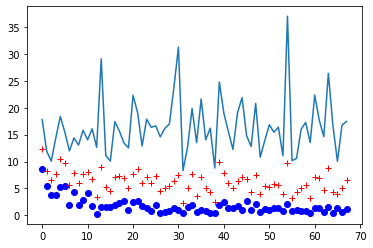

In [18]:
plt.plot(list(range(len(train_fepoch_errs))), train_fepoch_errs)
plt.plot(list(range(len(train_lepoch_errs))), train_lepoch_errs, 'bo')
plt.plot(list(range(len(train_avg_errs))), train_avg_errs, 'r+')

expect: ship
got: dog
vec: [-0.18029833  0.36651435  0.26686096  0.2965408  -0.32383344  0.30370373
  0.43690524  0.0179584   0.5934479   0.19543959]
probability: <zip object at 0x139e7f1c8>
err: 3.909822940826416


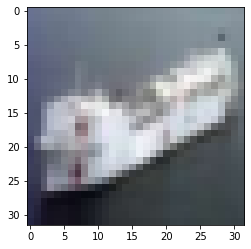

In [19]:
test_iteration(show=True)